In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [55]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import dask
from dask import dataframe as dd
import pyarrow as pa

data_path = Path(os.getcwd()).parent/"data"

# Use Pandas as reference for any diffrence in result

In [7]:
# Check Pandas <-> Dask datatype , operation
pdf = pd.read_csv(data_path/"split_aa")

array(['No', 'Yes'], dtype=object)

In [8]:
pdf.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

In [9]:
pdf.shape[0]

10000000

In [10]:
pdf["Errors?"].unique()

array([nan, 'Technical Glitch', 'Insufficient Balance', 'Bad PIN',
       'Bad PIN,Insufficient Balance', 'Bad Expiration',
       'Bad PIN,Technical Glitch', 'Bad Card Number', 'Bad CVV',
       'Bad Zipcode', 'Insufficient Balance,Technical Glitch',
       'Bad Card Number,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Bad Expiration',
       'Bad Expiration,Bad CVV', 'Bad Expiration,Insufficient Balance',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration,Technical Glitch',
       'Bad CVV,Technical Glitch', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance', 'Bad Zipcode,Technical Glitch'],
      dtype=object)

In [11]:
pdf["Use Chip"].unique()

array(['Swipe Transaction', 'Online Transaction', 'Chip Transaction'],
      dtype=object)

In [12]:
pdf["Is Fraud?"].unique()

array(['No', 'Yes'], dtype=object)

# Reading CSV with Dask

Reading CSV with parese `Year`, `Month`, `Day` and `Time` to `dt`, and specific dtype for `Errors?` as str to support __NULL__ value

In [17]:
# Reading CSV convert date, and specific dt
addf1 = dd.read_csv(
    data_path/"split_aa",
    parse_dates={"dt": [2, 3, 4, 5]},
    dtype={"Errors?": str}
)

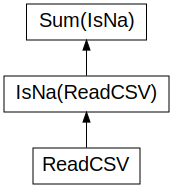

In [14]:
# Visualize compute graph
chk_null = ddf1.isna().sum()
chk_null.visualize()

In [15]:
chk_null.compute()

dt                      0
User                    0
Card                    0
Amount                  0
Use Chip                0
Merchant Name           0
Merchant City           0
Merchant State    1161291
Zip               1229064
MCC                     0
Errors?           9838028
Is Fraud?               0
dtype: int64

_parse_dates_ create column conflict, better avoid

In [16]:
ddf1["Use Chip"].unique().compute()

IndexError: An error occurred while calling the read_csv method registered to the pandas backend.
Original Message: list index out of range

In [18]:
ddf1["Errors?"].unique().compute()

IndexError: An error occurred while calling the read_csv method registered to the pandas backend.
Original Message: list index out of range

Check memory usage

In [19]:
ddf1.memory_usage(deep=True).compute()

Index                  1848
dt                 80000000
User               80000000
Card               80000000
Amount            549926712
Use Chip          658604480
Merchant Name      80000000
Merchant City     576296880
Merchant State    488289086
Zip                80000000
MCC                80000000
Errors?           325482745
Is Fraud?         510012013
dtype: int64

Specify all column dtype are more safe and memory efficient.  
- `string` -> `category`
- `int` -> `int16`  
Anyway, for data with Null, only suport type are `string`, `float64` or `category`

Also, with corrupted CSV, specify both column name and dtype could solve.   

In [33]:
# Incase of csv data have error rows, should 
# Specify column name & dtypes manually
# dtype 'category' also reduce amount of memory used
ddf_col = [
    "User",
    "Card",
    "Year",
    "Month",
    "Day",
    "Time",
    "Amount",
    "Use Chip",
    "Merchant Name",
    "Merchant City",
    "Merchant State",
    "Zip",
    "MCC",
    "Errors?",
    "Is Fraud?",
]

ddf_dtypes = {
    'User':'int16', 
    'Card':'int16',
    'Year':'int16',
    'Month':'int16', 
    'Day':'int16',
    'Time':'string', 
    'Amount':'string',
    'Use Chip':'category',
    'Merchant Name':'string',
    'Merchant City':'string',
    'Merchant State':'string',
    'Zip':'category',
    'MCC':'int16',
    'Errors?':'category',
    'Is Fraud?':'category',
}

In [34]:
# Use skiprows=1 for skipping header row
ddf1 = dd.read_csv(
    data_path/"split_aa",
    skiprows=1,
    names=ddf_col,
    dtype=ddf_dtypes,
)

In [35]:
ddf1["Use Chip"].unique().compute()

0     Swipe Transaction
0      Chip Transaction
0    Online Transaction
Name: Use Chip, dtype: category
Categories (3, object): ['Chip Transaction', 'Online Transaction', 'Swipe Transaction']

In [36]:
ddf1.memory_usage(deep=True).compute()

Index                  1848
User               20000000
Card               20000000
Year               20000000
Month              20000000
Day                20000000
Time              540000000
Amount            549926712
Use Chip           10003960
Merchant Name     684139678
Merchant City     576296880
Merchant State    516160070
Zip                29677488
MCC                20000000
Errors?            10024762
Is Fraud?          10001658
dtype: int64

In [60]:
ddf1.groupby(["Year", "Is Fraud?"], sort=True)["User"].nunique().compute()

Year  Is Fraud?
2002  No           179
2003  No           227
2004  No           279
2005  No           335
2006  No           390
2007  No           442
2008  No           506
2009  No           544
2010  No           578
2011  No           599
2012  No           602
2013  No           604
2014  No           610
2015  No           614
      Yes          156
2016  No           617
2017  No           615
2018  No           623
2019  No           650
2020  No           817
2016  Yes          309
2008  Yes          204
2019  Yes           93
2010  Yes          127
2006  Yes           99
2018  Yes           97
2013  Yes           65
2017  Yes           11
1999  No            67
2000  No            90
2001  No           126
      Yes           48
2014  Yes           38
2009  Yes           58
2007  Yes          107
2005  Yes           23
1998  No            41
2000  Yes           16
2012  Yes           69
2002  Yes            7
1996  No            15
1997  No            26
1999  Yes         

# Writing Dask as Parquet

In [ ]:
# Test write parquet write append
parquet_path = data_path/"combined.parquet"

for i, ddf in enumerate([ddf1, ddf2, ddf3]):
    if parquet_path.exists():
        print("Parquet Schema")
        print(dd.read_parquet(parquet_path).dtypes)
        print(i)
        print(ddf.dtypes)
        ddf.to_parquet(parquet_path, append=True, schema=pyarrow_schema, write_index=False)
    else:
        print(i)
        print(ddf.dtypes)
        ddf.to_parquet(parquet_path, schema=pyarrow_schema, write_index=False)

ddf = dd.read_parquet(parquet_path)

ddf.isnull().sum().compute()


In [2]:
pyarrow_schema = pa.schema([
    pa.field('User', pa.int64()),
    pa.field('Card', pa.int64()),
    pa.field('Year', pa.int64()),
    pa.field('Month', pa.int64()),
    pa.field('Day', pa.int64()),
    pa.field('Time', pa.string()),
    pa.field('Amount', pa.string()),
    pa.field('Use Chip', pa.string()),
    pa.field('Merchant Name', pa.string()),
    pa.field('Merchant City', pa.string()),
    pa.field('Merchant State', pa.string()),
    pa.field('Zip', pa.float64()),
    pa.field('MCC', pa.int64()),
    pa.field('Errors?', pa.string()),
    pa.field('Is Fraud?', pa.string()),
])

# Test write parquet write append
parquet_path = data_path/"combined.parquet"

for i, ddf in enumerate([ddf1, ddf2, ddf3]):
    if parquet_path.exists():
        print("Parquet Schema")
        print(dd.read_parquet(parquet_path).dtypes)
        print(i)
        print(ddf.dtypes)
        ddf.to_parquet(parquet_path, append=True, schema=pyarrow_schema, write_index=False)
    else:
        print(i)
        print(ddf.dtypes)
        ddf.to_parquet(parquet_path, schema=pyarrow_schema, write_index=False)

ddf = dd.read_parquet(parquet_path)

ddf.isnull().sum().compute()


FileNotFoundError: [Errno 2] No such file or directory: '/home/danny/Documents/PythonProject/Dask/notebook/data/split_aa'